# Curve fitting the synthetic complex sines

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os
# Curve fitting with Imfit
from lmfit import Parameters, minimize, fit_report
from sklearn.preprocessing import MinMaxScaler
from utils import plot_loc_right

plt.rcParams.update({'font.size': 14})

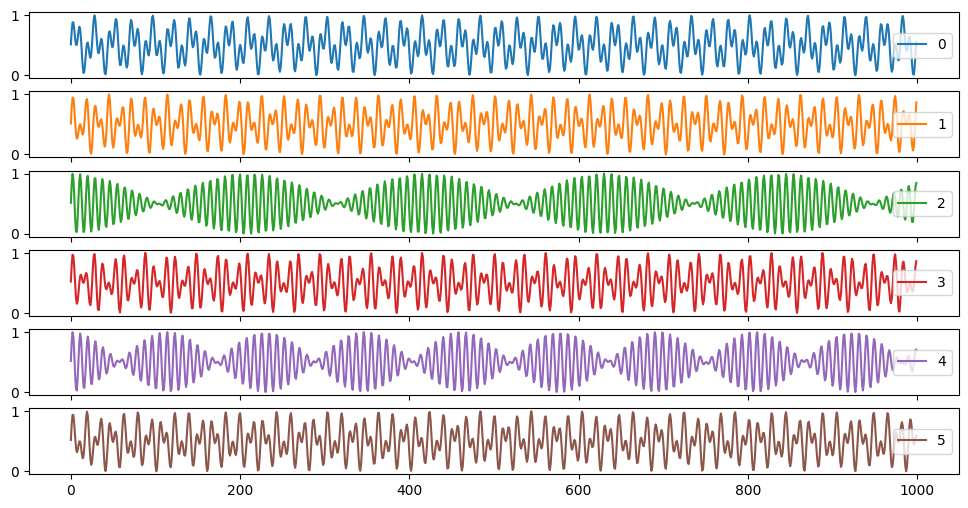

In [4]:
ori_data = np.loadtxt('complex_sine_data/comp_sine_123_1000_6.csv', delimiter = ",",skiprows = 1)
scaler = MinMaxScaler()
y = scaler.fit_transform(ori_data)
y = pd.DataFrame(y)

axes = y.plot(subplots=True, figsize=(12,6))
# flatten the array
axes = axes.flat  # .ravel() and .flatten() also work
# extract the figure object to use figure level methods
fig = axes[0].get_figure()

# iterate through each axes to use axes level methods
for ax in axes:
    
    ax.legend(loc='right')
    
# fig.suptitle(f'{clip_length} first samples of {dim}d sine signal data set', fontsize=22, y=0.95)
plt.show()

In [5]:
# Sine function to fit to
def sine_func(x, freq1, phase1, freq2, phase2):
    return (np.sin(x*freq1 + phase1) + np.sin(x*freq2 + phase2))/4 + 0.5

# Define the fitting function for the lmfit package
def sine_fitting_lmfit(params, x, y):
    freq1 = params['freq1']
    phase1 = params['phase1']    
    freq2 = params['freq2']
    phase2 = params['phase2']
    y_fit = (np.sin(x*freq1 + phase1) + np.sin(x*freq2 + phase2))/4 + 0.5
    return y_fit - y

### Test curve fitting function

The frequencies are 0.2763157894736842 and 0.7236842105263157
The phases are 3.6376335988934447 and 4.29902152596498


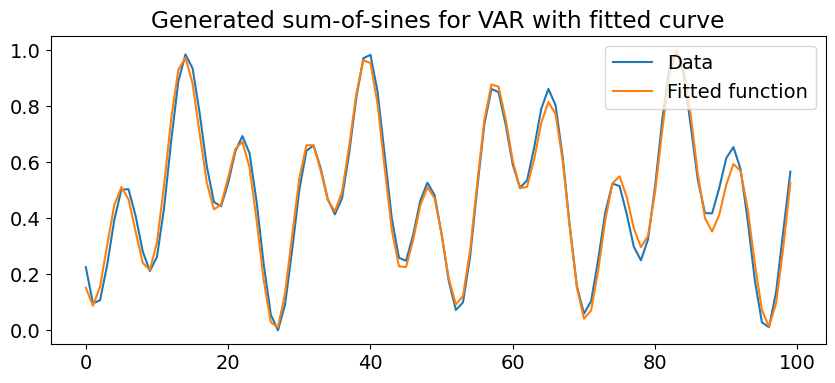

In [20]:
# Import y-data to fit

data_source = "VAR" #Options: TimeGAN 50k, TimeGAN 100k, VAR, LSTM

if data_source == "TimeGAN 50k":
    with open(os.path.join('synthetic_complex_sines', 'timegan', 'reproducable', 'comp_syn_sine_rep_50000_6_100_220524_00h41.json'), 'r') as file:
        y = json.load(file)
        y = y[0]
elif data_source == "TimeGAN 100k":
    with open(os.path.join('synthetic_complex_sines', 'timegan', 'reproducable', 'comp_syn_sine_rep_100000_6_100_220524_17h32.json'), 'r') as file:
        y = json.load(file)
        y = y[0]
elif data_source == "VAR":
    y = np.loadtxt('synthetic_complex_sines/VAR/comp_syn_sine_6_100_120524_13h34.csv', delimiter = ",",skiprows = 1)
elif data_source == "LSTM":
    y = np.loadtxt('synthetic_complex_sines/lstm/comp_syn_sine_6_98_120524_14h15.csv', delimiter = ",",skiprows = 1)

# with open('synthetic_complex_sines/timegan/comp_syn_sine_50000_6_100_120524_08h13.json', 'r') as file:
#     comp_sine_6_50000 = json.load(file)
# y_df = pd.DataFrame(comp_sine_6_50000[0])
# y = y_df[1].values


scaler = MinMaxScaler()
y = scaler.fit_transform(y)
y = pd.DataFrame(y)[0]

# Define x-axis values
x_data = range(0, len(y))

# Defining the various parameters
params = Parameters()
# Frequency is initially bounded between 0.25 and 0.75
params.add('freq1', min=0.25, max=0.75)
params.add('freq2', min=0.25, max=0.75)
# Phase is initially bounded between 0 and 0.1
params.add('phase1', min=0, max=2*np.pi)
params.add('phase2', min=0, max=2*np.pi)

# Calling the minimize function. Args contains the x and y data.
fitted_params = minimize(sine_fitting_lmfit, params, args=(x_data,y), method='brute')

# Getting the fitted values
freq1 = fitted_params.params['freq1'].value
freq2 = fitted_params.params['freq2'].value
phase1 = fitted_params.params['phase1'].value    
phase2 = fitted_params.params['phase2'].value    

# Printing the fitted values
print(f'The frequencies are {freq1} and {freq2}')
print(f'The phases are {phase1} and {phase2}')

# Pretty printing all the statistical data
# print(fit_report(fitted_params))

plt.figure(figsize=(10, 4))
plt.plot(x_data, y, label='Data')
plt.plot(x_data, sine_func(x_data, freq1, phase1, freq2, phase2),
         label='Fitted function')

plt.legend(loc='best')
plt.title(f'Generated sum-of-sines for {data_source} with fitted curve')
plt.show()

### Functions for complex sine fitting

In [21]:
def fit_curve_get_freq_phase(y):
    # Define x-axis values
    x_data = range(0, len(y))

    # Defining the various parameters
    params = Parameters()
    # Frequency is initially bounded between 0.25 and 0.75
    params.add('freq1', min=0.25, max=0.75)
    params.add('freq2', min=0.25, max=0.75)
    # Phase is initially bounded between 0 and 0.1
    params.add('phase1', min=0, max=2*np.pi)
    params.add('phase2', min=0, max=2*np.pi)

    # Calling the minimize function. Args contains the x and y data.
    fitted_params = minimize(sine_fitting_lmfit, params, args=(x_data,y), method='brute')

    # Getting the fitted values
    freq1 = fitted_params.params['freq1'].value
    freq2 = fitted_params.params['freq2'].value
    phase1 = fitted_params.params['phase1'].value    
    phase2 = fitted_params.params['phase2'].value  

    return freq1, phase1, freq2, phase2

def find_fitted_curve_2dplus(y_df):
    est_freqs = {}
    cnt = 0

    for feature in y_df.columns:

        y = y_df[feature]

        freq1, phase1, freq2, phase2 = fit_curve_get_freq_phase(y)

        # Calculate RSS
        rss = find_RSS(freq1, phase1, freq2, phase2, y_df[feature])

        est_freqs[f'f{cnt}'] = [freq1, phase1, freq2, phase2, rss/len(y)]
        cnt += 1
    return est_freqs

def fit_multivar_curve(filename):
    # Import y-data to fit
    with open(filename, 'r') as file:
        json_data = json.load(file)

    dim = filename.split('_')[6]
    freq_phase_rss_ests = {}
    y_df = pd.DataFrame(json_data[0])

    freq_phase_rss_ests = find_fitted_curve_2dplus(y_df) # Can only handle 2d or more
    
    return freq_phase_rss_ests

def estimation_deviations(true_freqs, true_sec_freq, freq_phase_rss_est):
    devs = []
    for key, value in freq_phase_rss_est.items():
        dev_pair1 = [round(100*np.abs(value[0] - true_freqs[key])/true_freqs[key], 2), round(100*np.abs(value[2] - true_sec_freq)/true_sec_freq, 2)]
        dev_pair2 = [round(100*np.abs(value[2] - true_freqs[key])/true_freqs[key], 2), round(100*np.abs(value[0] - true_sec_freq)/true_sec_freq, 2)]
        if np.sum(dev_pair1)<= np.sum(dev_pair2):
            devs.append([dev_pair1, value[4]])
    return devs

def find_RSS(freq1, phase1, freq2, phase2, y):
    fitted_curve = sine_func(range(len(y)), freq1, phase1, freq2, phase2)
    rss = np.sum(np.square(fitted_curve - y))
    return rss

true_freqs = {
    'f0': 0.27618179942547216,
    'f1': 0.45362088183519916,
    'f2': 0.7005994389758473,
    'f3': 0.5181010200169635,
    'f4': 0.6760433094646843,
    'f5': 0.41860832855463775,
    'f6': 0.37258167625880556,
    'f7': 0.4681378967076092,
    'f8': 0.5487997322439953
}

true_second_freq = 0.7303903783776162

### Fitting the generated complex sines from each of 3 models

In [22]:
import os

scaler_timegan = MinMaxScaler()
scaler_timegan_100k = MinMaxScaler()
scaler_var = MinMaxScaler()
scaler_lstm = MinMaxScaler()

with open(os.path.join('synthetic_complex_sines', 'timegan', 'reproducable', 'comp_syn_sine_rep_50000_6_100_220524_00h41.json'), 'r') as file:
    comp_sine_6_50000 = json.load(file)
comp_sine_6_50000_scaled = scaler_timegan.fit_transform(comp_sine_6_50000[1])
y_timegan = pd.DataFrame(comp_sine_6_50000_scaled)
y_timegan.name = 'timegan'

with open(os.path.join('synthetic_complex_sines', 'timegan', 'reproducable', 'comp_syn_sine_rep_100000_6_100_220524_17h32.json'), 'r') as file:
    comp_sine_6_100000 = json.load(file)
comp_sine_6_100000_scaled = scaler_timegan.fit_transform(comp_sine_6_100000[0])
y_timegan_100k = pd.DataFrame(comp_sine_6_100000_scaled)
y_timegan_100k.name = 'timegan_100k'

y_var = np.loadtxt(os.path.join('synthetic_complex_sines', 'VAR', 'comp_syn_sine_6_100_120524_13h34.csv'), delimiter = ",",skiprows = 1)
y_var = scaler_var.fit_transform(y_var)
y_var = pd.DataFrame(y_var)
y_var.name = 'var'

y_lstm = np.loadtxt(os.path.join('synthetic_complex_sines', 'lstm', 'comp_syn_sine_6_98_120524_14h15.csv'), delimiter = ",",skiprows = 1)
y_lstm = scaler_lstm.fit_transform(y_lstm)
y_lstm = pd.DataFrame(y_lstm)
y_lstm.name = 'lstm'

sines_to_fit = [y_timegan, y_timegan_100k, y_var, y_lstm]
comp_results = {'timegan': [], 'timegan_100k': [], 'var': [], 'lstm': []}

print(f'Done fitting data')

for df in sines_to_fit:
    ests = find_fitted_curve_2dplus(df)
    comp_results[df.name] = estimation_deviations(true_freqs, true_second_freq, ests)
    print(f'Deviation and rss estimation for {df.name} is done')



Done fitting data
Deviation and rss estimation for timegan is done
Deviation and rss estimation for timegan_100k is done
Deviation and rss estimation for var is done
Deviation and rss estimation for lstm is done


In [23]:
for key, val in comp_results.items():
    print(f'Results for {key}')
    for dim in val:
        print(f'Frequency deviations: {dim[0]} RSS: {dim[1]}')

Results for timegan
Frequency deviations: [0.05, 58.57] RSS: 0.04681539617356838
Frequency deviations: [13.12, 8.12] RSS: 0.03850387201706115
Frequency deviations: [14.28, 0.92] RSS: 0.050765228186916644
Frequency deviations: [7.05, 2.68] RSS: 0.055379572506760205
Frequency deviations: [8.85, 4.52] RSS: 0.047536770334362634
Results for timegan_100k
Frequency deviations: [9.48, 0.92] RSS: 0.015784287579881328
Frequency deviations: [1.52, 0.92] RSS: 0.013931226770805341
Frequency deviations: [3.3, 0.92] RSS: 0.01786136670034435
Frequency deviations: [0.95, 0.92] RSS: 0.022184857206005795
Frequency deviations: [20.2, 0.92] RSS: 0.04487508459747407
Frequency deviations: [10.01, 0.92] RSS: 0.040398216297497715
Results for var
Frequency deviations: [0.05, 0.92] RSS: 0.0015297079608044867
Frequency deviations: [1.52, 0.92] RSS: 0.003207427525854232
Frequency deviations: [0.46, 2.68] RSS: 0.006029211536083792
Frequency deviations: [0.95, 0.92] RSS: 0.0016781270840620286
Frequency deviations: [

[0.05, 58.57, 13.12, 8.12, 14.28, 0.92, 7.05, 2.68, 8.85, 4.52]
11.815999999999999
[9.48, 0.92, 1.52, 0.92, 3.3, 0.92, 0.95, 0.92, 20.2, 0.92, 10.01, 0.92]
4.248333333333333
[0.05, 0.92, 1.52, 0.92, 0.46, 2.68, 0.95, 0.92, 0.74, 0.92, 2.56, 0.92]
1.1300000000000001
[0.05, 0.92, 1.52, 0.92, 0.46, 2.68, 0.95, 0.92, 0.74, 0.92, 2.56, 0.92]
1.1300000000000001


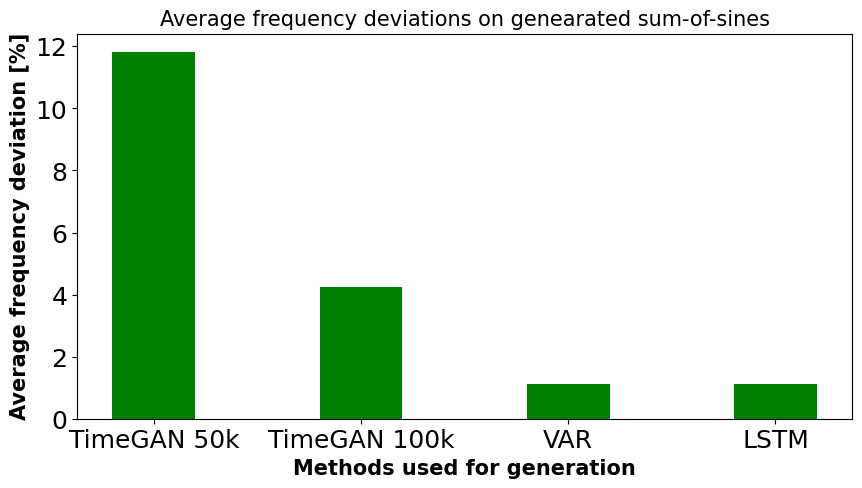

In [30]:
bar_labels = ['TimeGAN 50k', 'TimeGAN 100k', 'VAR', 'LSTM']
bar_values = []
plt.rcParams.update({'font.size': 18})

for key, vals in comp_results.items():
    all_devs = []
    # if key == 'timegan_100k':
    #     continue
    for dim in vals:
        all_devs.append(dim[0])
    flattened = list(np.concatenate(all_devs).flat)
    averaged = np.mean(flattened)
    print(flattened)
    print(averaged)
    bar_values.append(averaged)
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(bar_labels, bar_values, color ='g', 
        width = 0.4)
 
plt.xlabel("Methods used for generation", fontweight ='bold', fontsize = 15)
plt.ylabel("Average frequency deviation [%]", fontweight ='bold', fontsize = 15)
plt.title("Average frequency deviations on genearated sum-of-sines", fontsize = 15)
plt.show()

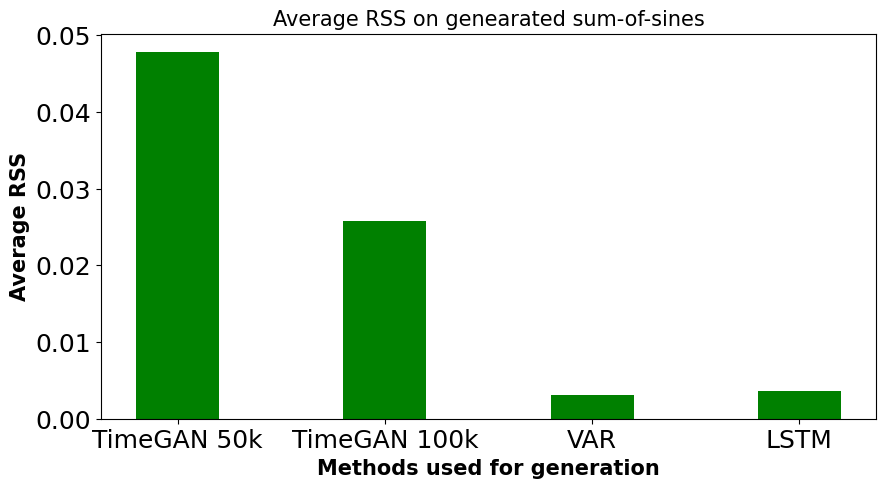

In [29]:
bar_labels = ['TimeGAN 50k', 'TimeGAN 100k', 'VAR', 'LSTM']
bar_values = []
for key, vals in comp_results.items():
    all_rss = []
    # if key == 'timegan_100k':
    #     continue
    for dim in vals:
        all_rss.append(dim[1])
    averaged = np.mean(all_rss)
    bar_values.append(averaged)
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(bar_labels, bar_values, color ='g', 
        width = 0.4)
 
plt.xlabel("Methods used for generation", fontweight ='bold', fontsize = 15)
plt.ylabel("Average RSS", fontweight ='bold', fontsize = 15)
plt.title("Average RSS on genearated sum-of-sines", fontsize = 15)
plt.show()

### Quick test to check if VAR and LSTM can handle the sum of 3 sinuses

In [2]:
# Sine function to fit to
def sine3_func(x, freq1, phase1, freq2, phase2, freq3, phase3):
    return (np.sin(x*freq1 + phase1) + np.sin(x*freq2 + phase2) + np.sin(x*freq3 + phase3))/6 + 0.5

# Define the fitting function for the lmfit package
def sine3_fitting_lmfit(params, x, y):
    freq1 = params['freq1']
    phase1 = params['phase1']    
    freq2 = params['freq2']
    phase2 = params['phase2']    
    freq3 = params['freq3']
    phase3 = params['phase3']
    y_fit = (np.sin(x*freq1 + phase1) + np.sin(x*freq2 + phase2) + np.sin(x*freq3 + phase3))/6 + 0.5
    return y_fit - y

The frequencies are 0.25, 0.4605263157894737 and 0.6447368421052632
The phases are 0.0, 0.0 and 0.0


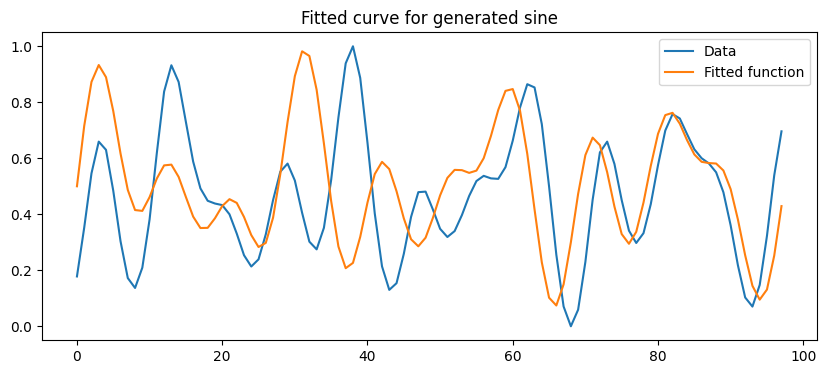

In [3]:
y = np.loadtxt('synthetic_complex_sines/lstm/extra_comp_syn_sine_6_98_130524_13h09.csv', delimiter = ",",skiprows = 1)

scaler = MinMaxScaler()
y = scaler.fit_transform(y)
y = pd.DataFrame(y)[0]

# Define x-axis values
x_data = range(0, len(y))

# Defining the various parameters
params = Parameters()
# Frequency is initially bounded between 0.25 and 0.75
params.add('freq1', min=0.25, max=0.75)
params.add('freq2', min=0.25, max=0.75)
params.add('freq3', min=0.25, max=0.75)
# Phase is initially bounded between 0 and 0.1
params.add('phase1', min=0, max=2*np.pi)
params.add('phase2', min=0, max=2*np.pi)
params.add('phase3', min=0, max=2*np.pi)

# Calling the minimize function. Args contains the x and y data.
fitted_params = minimize(sine3_fitting_lmfit, params, args=(x_data,y), method='brute')

# Getting the fitted values
freq1 = fitted_params.params['freq1'].value
freq2 = fitted_params.params['freq2'].value
freq3 = fitted_params.params['freq3'].value
phase1 = fitted_params.params['phase1'].value    
phase2 = fitted_params.params['phase2'].value    
phase3 = fitted_params.params['phase3'].value    

# Printing the fitted values
print(f'The frequencies are {freq1}, {freq2} and {freq3}')
print(f'The phases are {phase1}, {phase2} and {phase3}')

# Pretty printing all the statistical data
# print(fit_report(fitted_params))

plt.figure(figsize=(10, 4))
plt.plot(x_data, y, label='Data')
plt.plot(x_data, sine3_func(x_data, freq1, phase1, freq2, phase2, freq3, phase3),
         label='Fitted function')

plt.legend(loc='best')
plt.title('Fitted curve for generated sine')
plt.show()

The frequencies are 0.25, 0.4605263157894737 and 0.6447368421052632
The phases are 0.0, 0.0 and 0.0


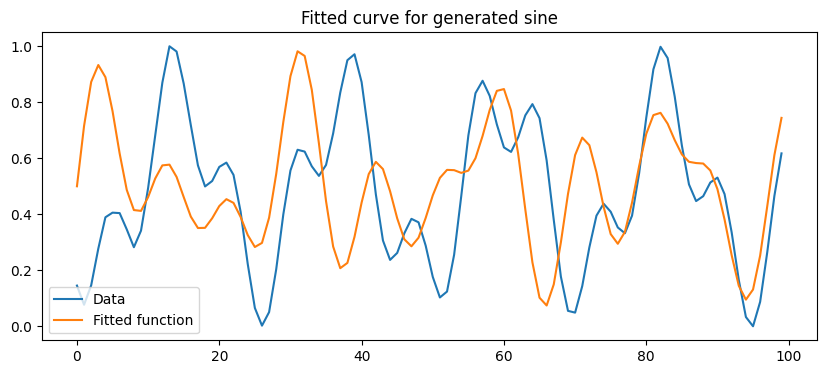

In [4]:
y = np.loadtxt('synthetic_complex_sines/VAR/extra_comp_syn_sine_6_100_130524_11h58.csv', delimiter = ",",skiprows = 1)

scaler = MinMaxScaler()
y = scaler.fit_transform(y)
y = pd.DataFrame(y)[0]

# Define x-axis values
x_data = range(0, len(y))

# Defining the various parameters
params = Parameters()
# Frequency is initially bounded between 0.25 and 0.75
params.add('freq1', min=0.25, max=0.75)
params.add('freq2', min=0.25, max=0.75)
params.add('freq3', min=0.25, max=0.75)
# Phase is initially bounded between 0 and 0.1
params.add('phase1', min=0, max=2*np.pi)
params.add('phase2', min=0, max=2*np.pi)
params.add('phase3', min=0, max=2*np.pi)

# Calling the minimize function. Args contains the x and y data.
fitted_params = minimize(sine3_fitting_lmfit, params, args=(x_data,y), method='brute')

# Getting the fitted values
freq1 = fitted_params.params['freq1'].value
freq2 = fitted_params.params['freq2'].value
freq3 = fitted_params.params['freq3'].value
phase1 = fitted_params.params['phase1'].value    
phase2 = fitted_params.params['phase2'].value    
phase3 = fitted_params.params['phase3'].value    

# Printing the fitted values
print(f'The frequencies are {freq1}, {freq2} and {freq3}')
print(f'The phases are {phase1}, {phase2} and {phase3}')

# Pretty printing all the statistical data
# print(fit_report(fitted_params))

plt.figure(figsize=(10, 4))
plt.plot(x_data, y, label='Data')
plt.plot(x_data, sine3_func(x_data, freq1, phase1, freq2, phase2, freq3, phase3),
         label='Fitted function')

plt.legend(loc='best')
plt.title('Fitted curve for generated sine')
plt.show()

In [ ]:
with open(os.path.join('synthetic_complex_sines', 'timegan', 'extra_comp_syn_sine_50000_6_100_140524_09h57.json'), 'r') as file:
    comp_sine_6_50000 = json.load(file)
scaler = MinMaxScaler()
y = scaler.fit_transform(comp_sine_6_50000[0])
y = pd.DataFrame(y)[0]

# Define x-axis values
x_data = range(0, len(y))

# Defining the various parameters
params = Parameters()
# Frequency is initially bounded between 0.25 and 0.75
params.add('freq1', min=0.25, max=0.75)
params.add('freq2', min=0.25, max=0.75)
params.add('freq3', min=0.25, max=0.75)
# Phase is initially bounded between 0 and 0.1
params.add('phase1', min=0, max=2*np.pi)
params.add('phase2', min=0, max=2*np.pi)
params.add('phase3', min=0, max=2*np.pi)

# Calling the minimize function. Args contains the x and y data.
fitted_params = minimize(sine3_fitting_lmfit, params, args=(x_data,y), method='brute')

# Getting the fitted values
freq1 = fitted_params.params['freq1'].value
freq2 = fitted_params.params['freq2'].value
freq3 = fitted_params.params['freq3'].value
phase1 = fitted_params.params['phase1'].value    
phase2 = fitted_params.params['phase2'].value    
phase3 = fitted_params.params['phase3'].value    

# Printing the fitted values
print(f'The frequencies are {freq1}, {freq2} and {freq3}')
print(f'The phases are {phase1}, {phase2} and {phase3}')

# Pretty printing all the statistical data
# print(fit_report(fitted_params))

plt.figure(figsize=(10, 4))
plt.plot(x_data, y, label='Data')
plt.plot(x_data, sine3_func(x_data, freq1, phase1, freq2, phase2, freq3, phase3),
         label='Fitted function')

plt.legend(loc='best')
plt.title('Fitted curve for generated sine')
plt.show()